# Download CMIP6 ssp245 data

This uses `netcdf-scm` to grab and process data.

See https://gitlab.com/netcdf-scm/netcdf-scm. This is based on one of the notebook examples.

Nicholls, Z, Lewis, J, Makin, M, et al. Regionally aggregated, stitched and de-drifted CMIP-climate data, processed with netCDF-SCM v2.0.0. Geosci Data J. 2021; 00: 1– 45. https://doi.org/10.1002/gdj3.113

In [1]:
from climateforcing.utils import mkdir_p
import netcdf_scm.io
import os
import glob
import requests
import zipfile
from tqdm import tqdm 
import scmdata
import matplotlib.pyplot as plt
import platform

In [2]:
platform.system()

'Darwin'

In [3]:
# file to save the downloaded zip in
ZIP_FILE = os.path.join("..", "data", "netcdf-scm", "ssp245_data.zip")
ZIP_FILE

'../data/netcdf-scm/ssp245_data.zip'

In [4]:
# directory in which to extract data
DATA_DIR = os.path.join("..", "data", "netcdf-scm", "cmip_data")
mkdir_p(DATA_DIR)

In [5]:
# from https://stackoverflow.com/questions/40419395/python-zipfile-extractall-ioerror-on-windows-when-extracting-files-from-long-pat
class ZipfileLongPaths(zipfile.ZipFile):

    def _extract_member(self, member, targetpath, pwd):
        targetpath = winapi_path(targetpath)
        return zipfile.ZipFile._extract_member(self, member, targetpath, pwd)
    
    
def winapi_path(dos_path, encoding=None):
    path = os.path.abspath(dos_path)
    if platform.system() == "Windows":
        if path.startswith("\\\\"):
            path = "\\\\?\\UNC\\" + path[2:]
        else:
            path = "\\\\?\\" + path 
    return path  

In [6]:
experiments = (
    "ssp245",
)
variables = (
    "tas",
    "rsdt",
    "rsut",
    "rlut",
)

# we only care about RFMIP models
# models = (
#     'CanESM5',
#     'CNRM-CM6-1',
#     'GFDL-CM4',
#     'GISS-E2-1-G',
#     'HadGEM3-GC31-LL',
#     'IPSL-CM6A-LR',
#     'MIROC6',
#     'NorESM2-LM'
# )

for exp in experiments:
    for var in variables:
        print(f"Downloading {exp} {var}")
        params = (
#                ("source_id", source_id),
            ("experiment_id", exp),
            ("variable_id", var),
            ("timeseriestype", "average-year-mid-year"),
            ("normalised", "21-yr-running-mean"),
        )
        url = "https://cmip6.science.unimelb.edu.au/api/v1/download_zip"

        r = requests.get(url, params=params)
        r.raise_for_status()

        with open(ZIP_FILE, "wb") as f:
            f.write(r.content)

        zip_ref = ZipfileLongPaths(ZIP_FILE, "r")
        zip_ref.extractall(DATA_DIR)
        zip_ref.close()

print("Finished")

Finished


In [7]:
available_files = glob.glob(winapi_path(os.path.join(DATA_DIR, "**", "ssp245", "**", "*.MAG")), recursive=True)
print(f"{len(available_files)} available files")
available_files[:5]

589 available files


['/Users/chris/git/chrisroadmap/fair2.1-calibrate/data/netcdf-scm/cmip_data/average-year-mid-year/CMIP6/ScenarioMIP/CAS/FGOALS-g3/ssp245/r1i1p1f1/Amon/rlut/gn/v20190818/NORMED_netcdf-scm_rlut_Amon_FGOALS-g3_ssp245_r1i1p1f1_gn_1850-2100.MAG',
 '/Users/chris/git/chrisroadmap/fair2.1-calibrate/data/netcdf-scm/cmip_data/average-year-mid-year/CMIP6/ScenarioMIP/CAS/FGOALS-g3/ssp245/r1i1p1f1/Amon/rsut/gn/v20190818/NORMED_netcdf-scm_rsut_Amon_FGOALS-g3_ssp245_r1i1p1f1_gn_1850-2100.MAG',
 '/Users/chris/git/chrisroadmap/fair2.1-calibrate/data/netcdf-scm/cmip_data/average-year-mid-year/CMIP6/ScenarioMIP/CAS/FGOALS-g3/ssp245/r1i1p1f1/Amon/rsdt/gn/v20190818/NORMED_netcdf-scm_rsdt_Amon_FGOALS-g3_ssp245_r1i1p1f1_gn_1850-2100.MAG',
 '/Users/chris/git/chrisroadmap/fair2.1-calibrate/data/netcdf-scm/cmip_data/average-year-mid-year/CMIP6/ScenarioMIP/CAS/FGOALS-g3/ssp245/r1i1p1f1/Amon/tas/gn/v20190818/NORMED_netcdf-scm_tas_Amon_FGOALS-g3_ssp245_r1i1p1f1_gn_1850-2100.MAG',
 '/Users/chris/git/chrisroadmap/fa

In [8]:
db = [
    netcdf_scm.io.load_mag_file(f, "CMIP6Output")
    for f in tqdm(available_files, position=0, leave=True)
]

100%|█████████████████████████████████████████| 589/589 [00:37<00:00, 15.54it/s]


In [9]:
db = scmdata.run_append(db).filter(region="World")
db.head()

time                                                                                     1850-07-01  \
activity_id climate_model member_id mip_era model       region scenario unit   variable               
ScenarioMIP FGOALS-g3     r1i1p1f1  CMIP6   unspecified World  ssp245   W m^-2 rlut        0.486719   
                                                                               rsut        0.339570   
                                                                               rsdt        0.028882   
                                                                        K      tas         0.153702   
                          r3i1p1f1  CMIP6   unspecified World  ssp245   W m^-2 rlut        0.486719   

time                                                                                     1851-07-01  \
activity_id climate_model member_id mip_era model       region scenario unit   variable               
ScenarioMIP FGOALS-g3     r1i1p1f1  CMIP6   unspecified World  ssp245   W m^-2 rlut        0.227888   
                                                                               rsut       -0.062932   
                                                                               rsdt        0.019431   
                                                                        K      tas        -0.050636   
                          r3i1p1f1  CMIP6   unspecified World  ssp245   W m^-2 rlut        0.227888   

time                                                                                     1852-07-01  \
activity_id climate_model member_id mip_era model       region scenario unit   variable               
ScenarioMIP FGOALS-g3     r1i1p1f1  CMIP6   unspecified World  ssp245   W m^-2 rlut        0.375933   
                                                                               rsut        0.096082   
                                                                               rsdt        0.017579   
                                                                        K      tas         0.013877   
                          r3i1p1f1  CMIP6   unspecified World  ssp245   W m^-2 rlut        0.375933   

time                                                                                     1853-07-01  \
activity_id climate_model member_id mip_era model       region scenario unit   variable               
ScenarioMIP FGOALS-g3     r1i1p1f1  CMIP6   unspecified World  ssp245   W m^-2 rlut        0.296362   
                                                                               rsut       -0.067775   
                                                                               rsdt       -0.001092   
                                                                        K      tas         0.026406   
                          r3i1p1f1  CMIP6   unspecified World  ssp245   W m^-2 rlut        0.296362   

time                                                                                     1854-07-01  \
activity_id climate_model member_id mip_era model       region scenario unit   variable               
ScenarioMIP FGOALS-g3     r1i1p1f1  CMIP6   unspecified World  ssp245   W m^-2 rlut        0.355644   
                                                                               rsut       -0.262578   
                                                                               rsdt       -0.028947   
                                                                        K      tas        -0.025644   
                          r3i1p1f1  CMIP6   unspecified World  ssp245   W m^-2 rlut        0.355644   

time                                                                                     1855-07-01  \
activity_id climate_model member_id mip_era model       region scenario unit   variable               
ScenarioMIP FGOALS-g3     r1i1p1f1  CMIP6   unspecified World  ssp245   W m^-2 rlut        0.207184   
                                                                               rs

In [10]:
required_vars = {"tas", "rlut", "rsut", "rsdt"}
force_first_year = 1850

out = []
for scdf in tqdm(db.groupby(["climate_model", "member_id", "scenario"]), position=0, leave=True):
    climate_model = scdf.get_unique_meta("climate_model", True)
    scenario = scdf.get_unique_meta("scenario", True)
    member_id = scdf.get_unique_meta("member_id", True)
    available_vars = scdf["variable"].unique()
    if not all([v in available_vars for v in required_vars]):
        print(f"Not all required data for {climate_model} {member_id} {scenario}")
        print("Available vars: {}".format(available_vars))
        continue

    rndt = (
        scdf.filter(variable="rsdt")
        .subtract(scdf.filter(variable="rsut"), op_cols={"variable": "rsdt - rsut"})
        .subtract(scdf.filter(variable="rlut"), op_cols={"variable": "rndt"})
    )

    keep = scmdata.run_append([scdf, rndt]).timeseries(
        time_axis="year", drop_all_nan_times=True
    )
    
    if keep.shape[1]<251:
        print(f"Time series is too short in {climate_model} {member_id} {scenario}")
        continue
    
    first_year = keep.columns[0]
    keep.columns = keep.columns.map(lambda x: force_first_year + x - first_year)

    out.append(scmdata.ScmRun(keep))

out = scmdata.run_append(out)
out.head()

16it [00:03,  7.04it/s]

Not all required data for CESM2-WACCM r4i1p1f1 ssp245
Available vars: ['tas']
Not all required data for CESM2-WACCM r5i1p1f1 ssp245
Available vars: ['tas']
Not all required data for CMCC-ESM2 r1i1p1f1 ssp245
Available vars: ['tas']


25it [00:05,  6.09it/s]

Time series is too short in CNRM-CM6-1 r7i1p1f2 ssp245
Time series is too short in CNRM-CM6-1 r8i1p1f2 ssp245


82it [00:12, 34.65it/s]

Not all required data for EC-Earth3 r10i1p1f1 ssp245
Available vars: ['tas']
Not all required data for EC-Earth3 r11i1p1f1 ssp245
Available vars: ['tas']
Not all required data for EC-Earth3 r12i1p1f1 ssp245
Available vars: ['tas']
Not all required data for EC-Earth3 r13i1p1f1 ssp245
Available vars: ['tas']
Not all required data for EC-Earth3 r15i1p1f1 ssp245
Available vars: ['tas']
Not all required data for EC-Earth3 r16i1p1f1 ssp245
Available vars: ['tas']
Not all required data for EC-Earth3 r17i1p1f1 ssp245
Available vars: ['tas']
Not all required data for EC-Earth3 r18i1p1f1 ssp245
Available vars: ['tas']
Not all required data for EC-Earth3 r19i1p1f1 ssp245
Available vars: ['tas']
Not all required data for EC-Earth3 r1i1p1f1 ssp245
Available vars: ['tas']
Not all required data for EC-Earth3 r20i1p1f1 ssp245
Available vars: ['tas']
Not all required data for EC-Earth3 r21i1p1f1 ssp245
Available vars: ['tas']
Not all required data for EC-Earth3 r22i1p1f1 ssp245
Available vars: ['tas']


117it [00:16,  7.88it/s]

Time series is too short in HadGEM3-GC31-LL r2i1p1f3 ssp245
Time series is too short in HadGEM3-GC31-LL r3i1p1f3 ssp245


135it [00:16, 22.15it/s]

Time series is too short in HadGEM3-GC31-LL r4i1p1f3 ssp245
Not all required data for INM-CM4-8 r1i1p1f1 ssp245
Available vars: ['tas']
Not all required data for INM-CM5-0 r1i1p1f1 ssp245
Available vars: ['tas']
Not all required data for IPSL-CM6A-LR r10i1p1f1 ssp245
Available vars: ['tas']
Not all required data for IPSL-CM6A-LR r11i1p1f1 ssp245
Available vars: ['tas']
Not all required data for IPSL-CM6A-LR r14i1p1f1 ssp245
Available vars: ['tas']
Not all required data for IPSL-CM6A-LR r1i1p1f1 ssp245
Available vars: ['tas']
Not all required data for IPSL-CM6A-LR r22i1p1f1 ssp245
Available vars: ['tas']
Not all required data for IPSL-CM6A-LR r25i1p1f1 ssp245
Available vars: ['tas']
Not all required data for IPSL-CM6A-LR r2i1p1f1 ssp245
Available vars: ['tas']
Not all required data for IPSL-CM6A-LR r3i1p1f1 ssp245
Available vars: ['tas']
Not all required data for IPSL-CM6A-LR r4i1p1f1 ssp245
Available vars: ['tas']
Not all required data for IPSL-CM6A-LR r5i1p1f1 ssp245
Available vars: [

141it [00:17, 14.07it/s]

Time series is too short in MIROC6 r12i1p1f1 ssp245
Not all required data for MIROC6 r13i1p1f1 ssp245
Available vars: ['rlut' 'tas']
Time series is too short in MIROC6 r14i1p1f1 ssp245
Time series is too short in MIROC6 r15i1p1f1 ssp245
Time series is too short in MIROC6 r16i1p1f1 ssp245


145it [00:18, 12.01it/s]

Time series is too short in MIROC6 r17i1p1f1 ssp245
Not all required data for MIROC6 r18i1p1f1 ssp245
Available vars: ['rlut' 'tas']
Time series is too short in MIROC6 r19i1p1f1 ssp245


148it [00:18, 10.15it/s]

Time series is too short in MIROC6 r20i1p1f1 ssp245
Not all required data for MIROC6 r21i1p1f1 ssp245
Available vars: ['rsut' 'rsdt' 'tas']


151it [00:19,  9.72it/s]

Time series is too short in MIROC6 r31i1p1f1 ssp245
Time series is too short in MIROC6 r32i1p1f1 ssp245


155it [00:19,  9.24it/s]

Time series is too short in MIROC6 r33i1p1f1 ssp245
Not all required data for MIROC6 r34i1p1f1 ssp245
Available vars: ['rlut' 'rsut' 'tas']
Time series is too short in MIROC6 r35i1p1f1 ssp245


157it [00:19,  9.48it/s]

Time series is too short in MIROC6 r36i1p1f1 ssp245
Not all required data for MIROC6 r37i1p1f1 ssp245
Available vars: ['rlut' 'rsdt' 'tas']
Time series is too short in MIROC6 r38i1p1f1 ssp245


159it [00:20,  8.26it/s]

Time series is too short in MIROC6 r39i1p1f1 ssp245


163it [00:20,  8.32it/s]

Time series is too short in MIROC6 r40i1p1f1 ssp245
Not all required data for MIROC6 r41i1p1f1 ssp245
Available vars: ['rsut' 'rsdt' 'tas']
Time series is too short in MIROC6 r4i1p1f1 ssp245
Not all required data for MIROC6 r5i1p1f1 ssp245
Available vars: ['rlut' 'rsut' 'tas']


167it [00:21,  9.53it/s]

Time series is too short in MIROC6 r6i1p1f1 ssp245
Not all required data for MIROC6 r7i1p1f1 ssp245
Available vars: ['rsut' 'rsdt' 'tas']
Time series is too short in MIROC6 r8i1p1f1 ssp245


169it [00:21,  7.89it/s]

Time series is too short in MIROC6 r9i1p1f1 ssp245


181it [00:23,  5.99it/s]

Time series is too short in MRI-ESM2-0 r2i1p1f1 ssp245
Time series is too short in MRI-ESM2-0 r3i1p1f1 ssp245


193it [00:23,  8.14it/s]

Time series is too short in MRI-ESM2-0 r4i1p1f1 ssp245
Not all required data for MRI-ESM2-0 r5i1p1f1 ssp245
Available vars: ['rsut' 'rsdt' 'tas']
Not all required data for NorESM2-LM r1i1p1f1 ssp245
Available vars: ['tas']
Not all required data for NorESM2-LM r2i1p1f1 ssp245
Available vars: ['tas']
Not all required data for NorESM2-LM r3i1p1f1 ssp245
Available vars: ['tas']
Not all required data for NorESM2-MM r1i1p1f1 ssp245
Available vars: ['tas']
Not all required data for NorESM2-MM r2i1p1f1 ssp245
Available vars: ['tas']
Not all required data for UKESM1-0-LL r1i1p1f2 ssp245
Available vars: ['rsut' 'tas']
Not all required data for UKESM1-0-LL r2i1p1f2 ssp245
Available vars: ['rsut' 'tas']
Not all required data for UKESM1-0-LL r3i1p1f2 ssp245
Available vars: ['rsut' 'tas']
Not all required data for UKESM1-0-LL r4i1p1f2 ssp245
Available vars: ['rsut' 'tas']
Not all required data for UKESM1-0-LL r8i1p1f2 ssp245
Available vars: ['rsut' 'tas']


time                                                                                                1850-01-01  \
activity_id climate_model member_id mip_era model       region scenario unit              variable               
ScenarioMIP ACCESS-CM2    r1i1p1f1  CMIP6   unspecified World  ssp245   W m^-2            rlut        0.327088   
                                                                                          rsut       -0.498356   
                                                                                          rsdt        0.028077   
                                                                        K                 tas        -0.039679   
                                                                        watt / meter ** 2 rndt        0.199345   

time                                                                                                1851-01-01  \
activity_id climate_model member_id mip_era model       region scenario unit              variable               
ScenarioMIP ACCESS-CM2    r1i1p1f1  CMIP6   unspecified World  ssp245   W m^-2            rlut       -0.079676   
                                                                                          rsut       -0.528236   
                                                                                          rsdt        0.017086   
                                                                        K                 tas        -0.024419   
                                                                        watt / meter ** 2 rndt        0.624998   

time                                                                                                1852-01-01  \
activity_id climate_model member_id mip_era model       region scenario unit              variable               
ScenarioMIP ACCESS-CM2    r1i1p1f1  CMIP6   unspecified World  ssp245   W m^-2            rlut        0.413225   
                                                                                          rsut       -0.484898   
                                                                                          rsdt        0.024452   
                                                                        K                 tas         0.138934   
                                                                        watt / meter ** 2 rndt        0.096125   

time                                                                                                1853-01-01  \
activity_id climate_model member_id mip_era model       region scenario unit              variable               
ScenarioMIP ACCESS-CM2    r1i1p1f1  CMIP6   unspecified World  ssp245   W m^-2            rlut        0.319467   
                                                                                          rsut       -0.168544   
                                                                                          rsdt       -0.003420   
                                                                        K                 tas         0.041122   
                                                                        watt / meter ** 2 rndt       -0.154343   

time                                                                                                1854-01-01  \
activity_id climate_model member_id mip_era model       region scenario unit              variable               
ScenarioMIP ACCESS-CM2    r1i1p1f1  CMIP6   unspecified World  ssp245   W m^-2            rlut        0.583721   
                                                                                          rsut       -0.266642   
                                                                                          rsdt       -0.030781   
                                                                        K                 tas         0.117104   
                                                                        watt / meter ** 2 rndt       -0.347860   

time 

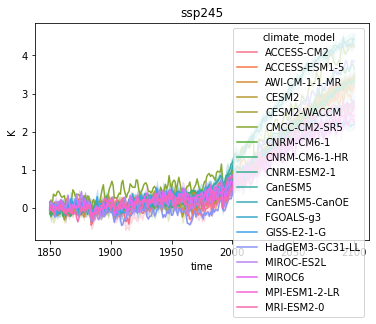

In [11]:
for sdf in out.groupby("scenario"):
    scenario = sdf.get_unique_meta("scenario", True)
    ax = sdf.filter(variable="tas").lineplot(hue="climate_model", time_axis="year")
    ax.set_title(scenario)
    plt.show()

In [12]:
out

<scmdata.ScmRun (timeseries: 480, timepoints: 251)>
Time:
	Start: 1850-01-01T00:00:00
	End: 2100-01-01T00:00:00
Meta:
	     activity_id climate_model member_id mip_era        model region scenario  \
	0    ScenarioMIP    ACCESS-CM2  r1i1p1f1   CMIP6  unspecified  World   ssp245   
	1    ScenarioMIP    ACCESS-CM2  r1i1p1f1   CMIP6  unspecified  World   ssp245   
	2    ScenarioMIP    ACCESS-CM2  r1i1p1f1   CMIP6  unspecified  World   ssp245   
	3    ScenarioMIP    ACCESS-CM2  r1i1p1f1   CMIP6  unspecified  World   ssp245   
	4    ScenarioMIP    ACCESS-CM2  r1i1p1f1   CMIP6  unspecified  World   ssp245   
	..           ...           ...       ...     ...          ...    ...      ...   
	475  ScenarioMIP    MRI-ESM2-0  r1i1p1f1   CMIP6  unspecified  World   ssp245   
	476  ScenarioMIP    MRI-ESM2-0  r1i1p1f1   CMIP6  unspecified  World   ssp245   
	477  ScenarioMIP    MRI-ESM2-0  r1i1p1f1   CMIP6  unspecified  World   ssp245   
	478  ScenarioMIP    MRI-ESM2-0  r1i1p1f1   CMIP6  unspecified

In [13]:
out.to_csv(os.path.join("..", "data", "netcdf-scm", "ssp245.csv"))